In [1]:
import jax.numpy as jnp
from jax import tree_util as jtu, nn, vmap, lax
from jax.experimental import sparse
from pymdp.jax.agent import Agent
import matplotlib.pyplot as plt
import seaborn as sns

from pymdp.jax.inference import smoothing_ovf

### Set up generative model and a sequence of observations. The A tensors, B tensors and observations are specified in such a way that  only later observations ($o_{t > 1}$) help disambiguate hidden states at earlier time points. This will demonstrate the importance of "smoothing" or retrospective inference

In [2]:
num_states = [3, 2]
num_obs = [2]
n_batch = 2

A_1 = jnp.array([[1.0, 1.0, 1.0], [0.0,  0.0,  1.]])
A_2 = jnp.array([[1.0, 1.0], [1., 0.]])

A_tensor = A_1[..., None] * A_2[:, None]

A_tensor /= A_tensor.sum(0)

A = [jnp.broadcast_to(A_tensor, (n_batch, num_obs[0], 3, 2)) ]

# create two transition matrices, one for each state factor
B_1 = jnp.broadcast_to(
    jnp.array([[0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [1.0, 0.0, 0.0]]), (n_batch, 3, 3)
)

B_2 = jnp.broadcast_to(
        jnp.array([[0.0, 1.0], [1.0, 0.0]]), (n_batch, 2, 2)
    )

B = [B_1[..., None], B_2[..., None]]

# for the single modality, a sequence over time of observations (one hot vectors)
obs = [jnp.broadcast_to(jnp.array([[1., 0.], # observation 0 is ambiguous with respect state factors
                                    [1., 0], # observation 0 is ambiguous with respect state factors
                                    [1., 0], # observation 0 is ambiguous with respect state factors
                                    [0., 1.]])[:, None], (4, n_batch, num_obs[0]) )] # observation 1 provides information about exact state of both factors 
C = [jnp.zeros((n_batch, num_obs[0]))] # flat preferences
D = [jnp.ones((n_batch, 3)) / 3., jnp.ones((n_batch, 2)) / 2.] # flat prior
E = jnp.ones((n_batch, 1))


In [9]:
print(len(A), A[0].shape)

1 (2, 2, 3, 2)


### Construct the `Agent`

In [4]:
pA = None
pB = None

agents = Agent(
        A=A,
        B=B,
        C=C,
        D=D,
        E=E,
        pA=None,
        pB=None,
        policy_len=3,
        control_fac_idx=None,
        policies=None,
        gamma=16.0,
        alpha=16.0,
        use_utility=True,
        onehot_obs=True,
        action_selection="deterministic",
        sampling_mode="full",
        inference_algo="ovf",
        num_iter=16,
        learn_A=False,
        learn_B=False,
        apply_batch=False

)


### Using `obs` and `policies`, pass in the arguments `outcomes`, `past_actions`, `empirical_prior` and `qs_hist` to `agent.infer_states(...)`

### Run first timestep of inference using `obs[0]`, no past actions, empirical prior set to actual prior, no qs_hist

In [5]:
# prior = agents.D
# qs_hist = None
# action_hist = []
# t =0
# first_obs = jtu.tree_map(lambda x: jnp.moveaxis(x[:t+1], 0, 1), obs)
# beliefs = agents.infer_states(first_obs, past_actions=None, empirical_prior=prior, qs_hist=qs_hist)
# actions = jnp.broadcast_to(agents.policies[0, 0], (2, 2))
# prior, qs_hist = agents.update_empirical_prior(actions, beliefs)
# action_hist.append(actions)


In [7]:
prior = agents.D
qs_hist = None
action_hist = []
for t in range(len(obs[0])):
    first_obs = jtu.tree_map(lambda x: jnp.moveaxis(x[:t+1], 0, 1), obs)
    beliefs = agents.infer_states(first_obs, past_actions=None, empirical_prior=prior, qs_hist=qs_hist)
    actions = jnp.broadcast_to(agents.policies[0, 0], (2, 2))
    prior, qs_hist = agents.infer_empirical_prior(actions, beliefs)
    action_hist.append(actions)

beliefs = jtu.tree_map(lambda x, y: jnp.concatenate([x[:, None], y], 1), agents.D, beliefs)

smoothed_beliefs = vmap(smoothing_ovf)(beliefs, agents.B, jnp.stack(action_hist, 1))


In [8]:
sparse_B = jtu.tree_map(lambda b: sparse.BCOO.fromdense(b, n_batch=n_batch), agents.B)

In [7]:
# sparse.sparsify(jnp.stack)([sparse_B[0], sparse_B[0]],axis=0)

In [8]:
smoothed_beliefs_sparse = vmap(smoothing_ovf)(beliefs, sparse_B, jnp.stack(action_hist, 1))

AssertionError: 

### Try the non-vmapped version of `smoothing_ovf`


In [12]:
take_first = lambda pytree: jtu.tree_map(lambda leaf: leaf[0], pytree)

beliefs_single = take_first(beliefs)
sparse_B_single = jtu.tree_map(lambda b: sparse.BCOO.fromdense(b[0]), agents.B)
actions_single = jnp.stack(action_hist, 1)[0]

smoothed_beliefs = smoothing_ovf(beliefs_single, sparse_B_single, actions_single)

### Now we can plot that pair of filtering / smoothing distributions for the single batch / single agent, that we ran

Text(0.5, 1.0, 'Filtered beliefs')

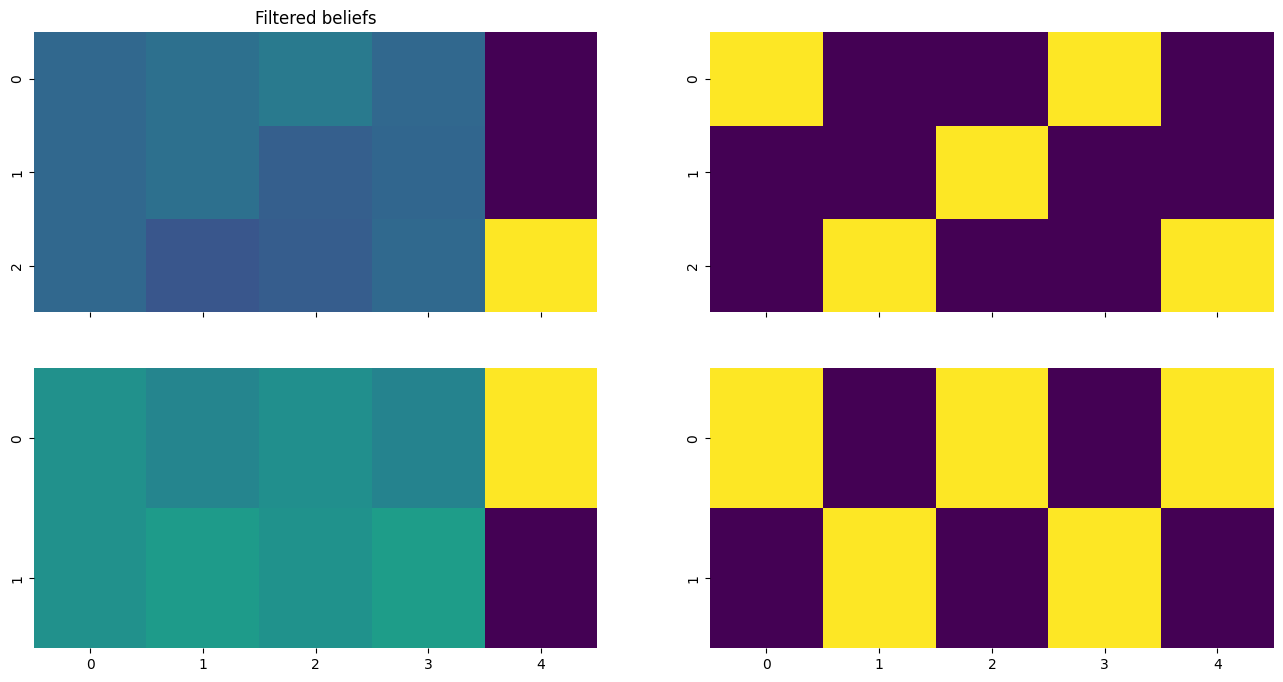

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=True)

sns.heatmap(beliefs_single[0].mT, ax=axes[0, 0], cbar=False, vmax=1., vmin=0., cmap='viridis')
sns.heatmap(beliefs_single[1].mT, ax=axes[1, 0], cbar=False, vmax=1., vmin=0., cmap='viridis')

sns.heatmap(smoothed_beliefs[0][0].mT, ax=axes[0, 1], cbar=False, vmax=1., vmin=0., cmap='viridis')
sns.heatmap(smoothed_beliefs[1][0].mT, ax=axes[1, 1], cbar=False, vmax=1., vmin=0., cmap='viridis')

axes[0, 0].set_title('Filtered beliefs')

In [ ]:
# f_id, batch_id = 0, 0
# filtered_qs = beliefs[f_id][batch_id] # this assuming the code below is being tree_mapped over factors (first index is factor_id), and vmapped over batches (second index is batch_id)
# sparse_b = sparse_B[f_id][batch_id]
# b = agents.B[f_id][batch_id]
# past_actions = jnp.stack(action_hist, 1)
# actions = past_actions[batch_id][...,f_id]

In [ ]:
# qs_last = filtered_qs[-1]
# qs_filter = filtered_qs[:-1]
# # time_b = jnp.moveaxis(b[..., actions], -1, 0)
# time_b = sparse_b[...,actions].transpose([sparse_b.ndim-1] + list(range(sparse_b.ndim-1)))
# qs_joint= time_b * jnp.expand_dims(qs_filter, -1)

In [ ]:
# sparse_b[...,actions].transpose([sparse_b.ndim-1] + list(range(sparse_b.ndim-1))).shape

In [ ]:
# qs_last = filtered_qs[-1]
# qs_filter = filtered_qs[:-1]

# # conditional dist - timestep x s_{t+1} | s_{t}
# time_b = jnp.moveaxis(b[..., actions], -1, 0)

# # joint dist - timestep x s_{t+1} x s_{t}
# qs_joint = time_b * jnp.expand_dims(qs_filter, -1)

# # cond dist - timestep x s_{t} | s_{t+1}
# qs_backward_cond = jnp.moveaxis(
#     qs_joint / qs_joint.sum(-2, keepdims=True), -2, -1
# )

# def step_fn(qs_smooth_past, backward_b):
#     qs_joint = backward_b * qs_smooth_past
#     qs_smooth = qs_joint.sum(-1)
    
#     return qs_smooth, (qs_smooth, qs_joint)

# # seq_qs will contain a sequence of smoothed marginals and joints
# _, seq_qs = lax.scan(
#     step_fn,
#     qs_last,
#     qs_backward_cond,
#     reverse=True,
#     unroll=2
# )

# # we add the last filtered belief to smoothed beliefs
# qs_smooth_all = jnp.concatenate([seq_qs[0], jnp.expand_dims(qs_last, 0)], 0)

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=True)

sns.heatmap(beliefs[0][0].mT, ax=axes[0, 0], cbar=False, vmax=1., vmin=0., cmap='viridis')
sns.heatmap(beliefs[1][0].mT, ax=axes[1, 0], cbar=False, vmax=1., vmin=0., cmap='viridis')

sns.heatmap(smoothed_beliefs[0][0][0].mT, ax=axes[0, 1], cbar=False, vmax=1., vmin=0., cmap='viridis')
sns.heatmap(smoothed_beliefs[1][0][0].mT, ax=axes[1, 1], cbar=False, vmax=1., vmin=0., cmap='viridis')

axes[0, 0].set_title('Filtered beliefs')

In [9]:
from opt_einsum import contract

In [10]:
type(sparse_B[0])

jax.experimental.sparse.bcoo.BCOO

In [ ]:

contract('ijk->k', sparse_B[0][...,0].todense())